# 数据加载和处理教程

**作者**：[Sasank Chilamkurthy](https://chsasank.github.io)

对于任何机器学习的问题，都会有大量的努力被用在准备数据上面。
PyTorch提供了许多工具来简化数据加载、增强代码可读性。
着这个教程中，我们将看到如何在一个非凡的数据集上进行加载、预处理和扩充。

要运行这个教程，确定安装了以下包：

- `scikit-image`：用于图像IO和变换
- `pandas`：用于简化CVS解析




In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

我们要处理的数据集是人脸姿态。
面部标注就像这样：

![](https://pytorch.org/tutorials/_images/landmarked_face2.png)

总之，每个面部都注释了68个不同的关键特征点(landmark)。

> **注意**：
>
> --------
>
> 从<https://download.pytorch.org/tutorial/faces.zip>下载这个数据集，图片在目录`data/faces/`。
> 这个数据集实际上是通过对来自imagenet标注为"face"的一些图像应用[dlib](https://blog.dlib.net/2014/08/real-time-face-pose-estimation.html)这一优秀的姿态估计法得来的。


这个数据集里有一个带有标注的CSV文件，它看起来是这样的：


| image_name | part_0_x | part_0_y | part_1_x | part_1_y | part_2_x | ... | part_67_x | part_67_y |
| ---------- | -------- | -------- | -------- | -------- | -------- | --- | --------- | --------- |   
| 0805personali01.jpg | 27 | 83 | 27 | 98 | ... | ... | 84 | 134 |
| 1084239450_e76e00b7e7.jpg | 70 | 236 | 71 | 257 | ... | ... | 128 | 312 |

读取CSV并把标注数据放到(N,2)数组中，其中N是关键特征点的数量。

In [2]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


编写一个可以显示图像及其关键特征点的简单辅助函数，用它显示样本。




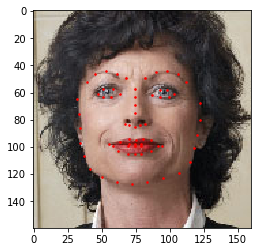

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)
plt.show()

## Dataset 类

`torch.utils.data.Dataset` 是针对数据集的抽象类.

我们自己的数据集类应该继承自`Dataset`，覆盖以下方法：

- `__len__`：用`len(dataset)`可以返回数据集的大小。
-  `__getitem__`：使得像`dataset[i]`这样的索引操作可以用于访问第$i$个样本

现在，为我们自己的面部关键特征点数据集创建一个`Dataset`类。
我们在`__init__`读取CSV，但是把读取图片的工作留给`__getitem__`。
这样可以节省内存，因为图片不是一次性的全部读进内存，而是需要时才读取。


我们的数据集中的样本将是一个`dict`：

```python
{'image': image, 'landmarks': landmarks}
```

我们的数据集将提供一个可选的参数`transform`，这样任何需要的处理过程可以在样本上执行。
在下一节可以看到`transform`的作用。




In [4]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

实例化这个类并且遍历数据样本，打印头4个样本的大小和关键特征点。




0 (324, 215, 3) (68, 2)


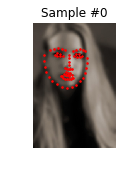

1 (500, 333, 3) (68, 2)


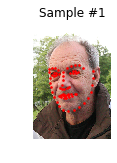

2 (250, 258, 3) (68, 2)


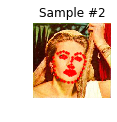

3 (434, 290, 3) (68, 2)


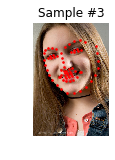

In [5]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', root_dir='data/faces/')

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

## 变换

观察上面的样本，我们发现一个问题——图像不是同样的大小。
大多数神经网络都期待固定大小的图像。
因此，需要编写一些预处理代码。
我们创建三种变换：

- `Rescale`: 缩放图像
- `RandomCrop`: 随机裁剪图像。这算是数据增加扩充。
- `ToTensor`: 将numpy图像转为torch图像（需要交换坐标轴）。

把他们编写为可调用类，而不是函数，这样，每次调用就不用传递变换的参数。
为此，我们需要实现`__call__`方法，如果有必要，还有`__init__`方法。
然后像这样进行变换：

```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

请注意以下这些变换如何被应用于图像和关键特征点。




In [6]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

### 组合转换

下面，在样本上应用转换。

假设我们想要将图像的短边重新缩放到256，然后从中随机裁剪一个224的正方形。
也就是说，我们需要组合`Rescale`和`RandomCrop`转换。
`torchvision.transforms.Compose`是一个简单的可调用类，它用于完成这样的工作。




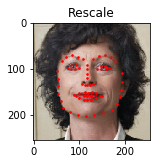

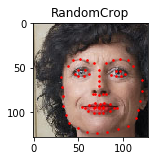

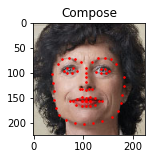

In [7]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## 遍历数据集

把上面的你同放在一起，创建一个带有组合变换的数据集。
总而言之，每次从这个数据集采用的时候：

- 从文件中即时的读取图像
- 对读取的图像进行变换
- 由于其中一个变化是随机的，数据在采样时是扩充的

我们可以使用之前用过的`for ... in`循环遍历数据集。




In [8]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['landmarks'].size())
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


不过，简单的`for`循环遍历数据让我们丢失了不少特性，特别是：

- 数据的批处理
- 乱序排列数据
- 使用`multiprocessing`并行加载数据。

`torch.utils.data.DataLoader`是一个迭代器，它提供了所有这些特性。
下面的参数应该清除的说明了问题。
其中一个有趣的参数是`collate_fn`，可以指定哪些具体的样本需要在批次中使用`collate_fn`进行整理。
当然，大多数情况下默认的整理(collat)就可以了。




0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


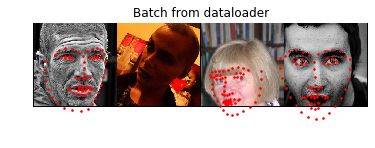

In [9]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

后记：torchvision
----------------------

在这个教程中，我们已经看到了如何编写和使用`Dataset`,`transform`和`Dataloader`。

`torchvision`包提供了一些常用的数据集和变换方法，用它，甚至可能不用编写自己的类。

`torchvision`中还有更通用的数据集类型，其中一个是`ImageFolder`。
它假定图像按以下方式组织：

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png

其中，'ants'、'bees'等是分类标签。
它具备类似`PIL.Image`的通用变换方法，像`RandomHorizontalFlip`、`Scale`。

我们可以使用它们来编写像这样的`Dataloader`：

```python
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
      transforms.RandomSizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
  ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                         transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                           batch_size=4, shuffle=True,
                                           num_workers=4)
```

有关教程的代码示例，请参阅[迁移学习教程](../transfer_learning_tutorial)。

